In [1]:

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

#set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Python built-in RNG


# Load data
images = np.load('images.npy')
labels = np.load('labels.npy')

# Normalize images to [0, 1] and add channel dimension
images = images.astype('float32') / 255.0
images = np.expand_dims(images, -1) 

print("Images shape:", images.shape)

# split into train, val and test sets
X_train, X_val_test, y_train_orig, y_val_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val_orig, y_test_orig = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


2025-11-06 23:14:02.958780: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 23:14:02.988289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-06 23:14:07.781216: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Images shape: (18000, 150, 150, 1)


Task 2.1 Classification

Creating 24 categories (30 minute interval)

In [2]:
def to_class_label(hours, minutes, interval=30):
    # into 30 minute intervals (interval 0 = 00:00-00:29)
    total_minutes = (hours % 12) * 60 + minutes
    return total_minutes // interval  

# Create class labels for 24 categories (30 minute intervals)
y_train_24 = to_class_label(y_train_orig[:,0], y_train_orig[:,1])
y_val_24 = to_class_label(y_val_orig[:,0], y_val_orig[:,1])
y_test_24 = to_class_label(y_test_orig[:,0], y_test_orig[:,1])


y_train_24 = to_categorical(y_train_24, 24)
y_val_24 = to_categorical(y_val_24, 24)
y_test_24 = to_categorical(y_test_24, 24)

In [3]:
def interval_label_to_time(label, interval=30):
    # Convert class label back to hours and minutes
    total_minutes = label * interval
    hours = (total_minutes // 60) % 12
    minutes = total_minutes % 60
    return hours, minutes

def common_sense_err(y_actual_time, y_pred, interval):
    # get y_actual_time hours
    actual_hours = y_actual_time[:, 0]
    actual_minutes = y_actual_time[:, 1]
    actual_total_minutes = actual_hours * 60 + actual_minutes
    
    # compare with predicted class labels
    pred_total_minutes = y_pred * interval
    
    # calculate absolute difference
    diff = np.abs(actual_total_minutes - pred_total_minutes)
    circular_diff = np.minimum(diff, 720 - diff)
    mean_error = int(np.mean(circular_diff))
    
    # convert back into hours and minutes
    mean_error_hours = mean_error // 60
    mean_error_minutes = mean_error % 60
    
    return mean_error_hours, mean_error_minutes

In [43]:
results_classification = {
        "train": [],
        "val": [],
        "test": []
    }

In [5]:
def evaluation_classification(checkpoint_path, X_train, X_val, X_test, y_test, interval=None, y_train_orig=y_train_orig, y_val_orig=y_val_orig, y_test_orig=y_test_orig):
    
    model = load_model(checkpoint_path)
    y_pred = np.argmax(model.predict(X_train), axis=1)
    h, m = common_sense_err(y_train_orig, y_pred, interval)
    results_classification["train"].append((h*60) +m)
    print(f'Common Sense Error Train set: {h}h {m}m')

    y_pred = np.argmax(model.predict(X_val), axis=1)
    h, m = common_sense_err(y_val_orig, y_pred, interval)
    results_classification["val"].append((h*60) +m)
    print(f'Common Sense Error val set: {h}h {m}m')

    # evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print('Test accuracy:', test_acc)

    y_pred = np.argmax(model.predict(X_test), axis=1)
    h, m = common_sense_err(y_test_orig, y_pred, interval)
    results_classification["test"].append((h*60) +m)
    print(f'Common Sense Error: {h}h {m}m')
    


In [6]:

pixel_size = X_train.shape[1], X_train.shape[2], X_train.shape[3]
def model_classification(pixel_size, num_categories):
    model = models.Sequential([
        layers.Input(shape=pixel_size),
        layers.Conv2D(32,7,padding='same',activation='relu',strides=3),
        layers.MaxPooling2D(pool_size=2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv2D(64,3,padding='same',activation='relu', strides=2),
        layers.Conv2D(128,3,padding='same',activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv2D(256,3,padding='same',activation='relu'),
        layers.Flatten(),
        layers.Dense(256,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256 ,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_categories,activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [43]:

classification_checkpoint = ModelCheckpoint(
    filepath="model_classification_30.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=False
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.9,
    patience=5,
    verbose=1,
    min_lr=1e-4
)

model_classification_30min_interval = model_classification(pixel_size, num_categories=24)
history_30 = model_classification_30min_interval.fit(X_train, y_train_24, epochs=200, batch_size=64, validation_data=(X_val, y_val_24), callbacks=[classification_checkpoint, lr_scheduler])

Epoch 1/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0487 - loss: 3.8243 - val_accuracy: 0.0361 - val_loss: 3.5429 - learning_rate: 0.0010
Epoch 2/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1000 - loss: 3.0819 - val_accuracy: 0.0572 - val_loss: 3.3148 - learning_rate: 0.0010
Epoch 3/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1692 - loss: 2.5202 - val_accuracy: 0.1322 - val_loss: 2.8252 - learning_rate: 0.0010
Epoch 4/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2290 - loss: 2.2049 - val_accuracy: 0.2406 - val_loss: 2.1631 - learning_rate: 0.0010
Epoch 5/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2851 - loss: 1.9775 - val_accuracy: 0.3000 - val_loss: 2.0065 - learning_rate: 0.0010
Epoch 6/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3500 - loss: 1.7605 - val_accuracy: 0.2044 - val_loss: 2.3631 - learning_rate: 0.0010
Epoch 7/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4097 - los

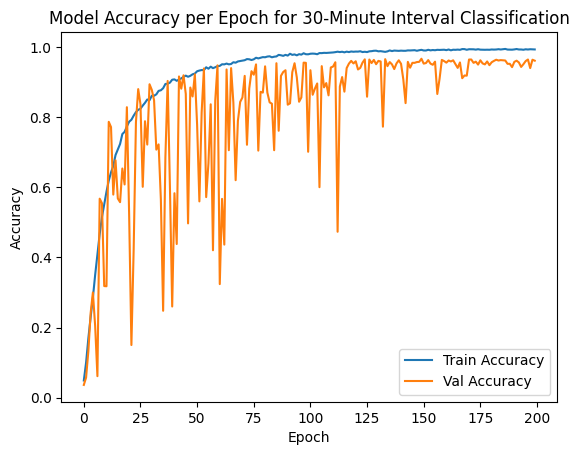

In [44]:
plt.title('Model Accuracy per Epoch for 30-Minute Interval Classification')
plt.plot(history_30.history['accuracy'], label='Train Accuracy')
plt.plot(history_30.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_30min_interval.png')
plt.show()

Evaluate test set

In [44]:


evaluation_classification("model_classification_30.keras", X_train, X_val, X_test, y_test_24, interval=30)

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Common Sense Error Train set: 0h 14m
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Common Sense Error val set: 0h 15m
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9661 - loss: 0.1294
Test accuracy: 0.9661111235618591
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Common Sense Error: 0h 15m


Classification 72 labels (10 minute intervals)

In [23]:
# Create class labels for 72 categories (10 minute intervals)
y_train_72 = to_class_label(y_train_orig[:,0], y_train_orig[:,1], interval=10)
y_val_72 = to_class_label(y_val_orig[:,0], y_val_orig[:,1], interval=10)
y_test_72 = to_class_label(y_test_orig[:,0], y_test_orig[:,1], interval=10)

y_train_72 = to_categorical(y_train_72, 72)
y_val_72 = to_categorical(y_val_72, 72)
y_test_72 = to_categorical(y_test_72, 72)

In [24]:

classification_checkpoint = ModelCheckpoint(
    filepath="model_classification_10.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=False
)
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.9,
    patience=5,
    verbose=1,
    min_lr=1e-4
)

model_classification_10min_interval = model_classification(pixel_size, num_categories=72)
history_10 = model_classification_10min_interval.fit(X_train, y_train_72, epochs=200, batch_size=64, validation_data=(X_val, y_val_72), callbacks=[classification_checkpoint, lr_scheduler])

Epoch 1/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.0148 - loss: 4.9969 - val_accuracy: 0.0100 - val_loss: 4.4475 - learning_rate: 0.0010
Epoch 2/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0239 - loss: 4.5464 - val_accuracy: 0.0172 - val_loss: 4.5588 - learning_rate: 0.0010
Epoch 3/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0661 - loss: 3.8650 - val_accuracy: 0.0500 - val_loss: 4.1024 - learning_rate: 0.0010
Epoch 4/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1517 - loss: 2.9564 - val_accuracy: 0.0211 - val_loss: 6.8074 - learning_rate: 0.0010
Epoch 5/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2262 - loss: 2.4093 - val_accuracy: 0.0167 - val_loss: 9.2587 - learning_rate: 0.0010
Epoch 6/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2795 - loss: 2.1198 - val_accuracy: 0.1239 - val_loss: 3.6768 - learning_rate: 0.0010
Epoch 7/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3239 - loss:

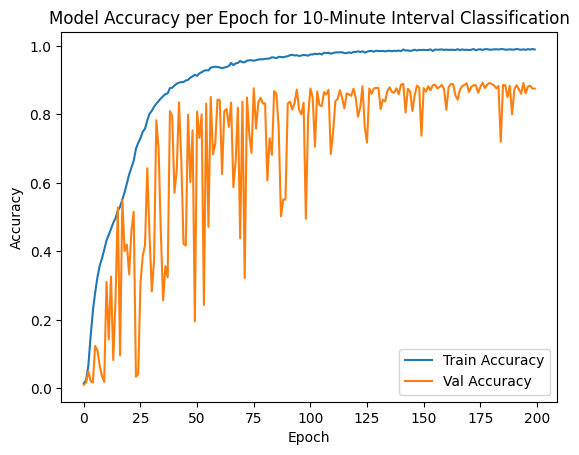

In [25]:
plt.title('Model Accuracy per Epoch for 10-Minute Interval Classification')
plt.plot(history_10.history['accuracy'], label='Train Accuracy')
plt.plot(history_10.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_10min_interval.png')
plt.show()

In [45]:
evaluation_classification("model_classification_10.keras", X_train, X_val, X_test, y_test_72, interval=10)

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Common Sense Error Train set: 0h 4m
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Common Sense Error val set: 0h 11m
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9094 - loss: 0.3333
Test accuracy: 0.9094444513320923
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Common Sense Error: 0h 9m


5 minute intervals

In [27]:
# Create class labels for 144 categories (5 minute intervals)
y_train_144 = to_class_label(y_train_orig[:,0], y_train_orig[:,1], interval=5)
y_val_144 = to_class_label(y_val_orig[:,0], y_val_orig[:,1], interval=5)
y_test_144 = to_class_label(y_test_orig[:,0], y_test_orig[:,1], interval=5)

y_train_144 = to_categorical(y_train_144, 144)
y_val_144 = to_categorical(y_val_144, 144)
y_test_144 = to_categorical(y_test_144, 144)

In [28]:

classification_checkpoint = ModelCheckpoint(
    filepath="model_classification_5.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=False
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.9,
    patience=5,
    verbose=1,
    min_lr=1e-4
)
model_classification_5min_interval = model_classification(pixel_size, num_categories=144)
history_5 = model_classification_5min_interval.fit(X_train, y_train_144, epochs=200, batch_size=64, validation_data=(X_val, y_val_144), callbacks=[classification_checkpoint, lr_scheduler])

Epoch 1/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0063 - loss: 5.6176 - val_accuracy: 0.0056 - val_loss: 5.1145 - learning_rate: 0.0010
Epoch 2/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0122 - loss: 5.2155 - val_accuracy: 0.0056 - val_loss: 5.9302 - learning_rate: 0.0010
Epoch 3/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0308 - loss: 4.6811 - val_accuracy: 0.0350 - val_loss: 4.5316 - learning_rate: 0.0010
Epoch 4/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0830 - loss: 3.8469 - val_accuracy: 0.0244 - val_loss: 5.0708 - learning_rate: 0.0010
Epoch 5/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1637 - loss: 2.9829 - val_accuracy: 0.0083 - val_loss: 22.4194 - learning_rate: 0.0010
Epoch 6/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2360 - loss: 2.4648 - val_accuracy: 0.0544 - val_loss: 4.8437 - learning_rate: 0.0010
Epoch 7/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2962 - loss

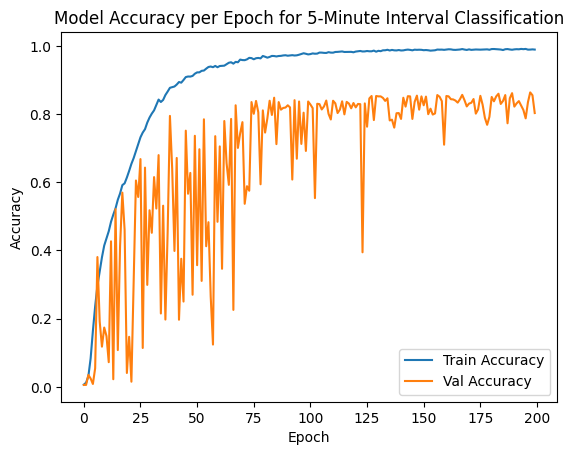

In [29]:
plt.title('Model Accuracy per Epoch for 5-Minute Interval Classification')
plt.plot(history_5.history['accuracy'], label='Train Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_5min_interval.png')
plt.show()

In [46]:
evaluation_classification("model_classification_5.keras", X_train, X_val, X_test, y_test_144, interval=5)

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Common Sense Error Train set: 0h 2m
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Common Sense Error val set: 0h 11m
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8550 - loss: 0.5057
Test accuracy: 0.8550000190734863
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Common Sense Error: 0h 12m


1 minute intervals

In [31]:
# Create class labels for 720 categories (1 minute intervals)
y_train_720 = to_class_label(y_train_orig[:,0], y_train_orig[:,1], interval=1)
y_val_720 = to_class_label(y_val_orig[:,0], y_val_orig[:,1], interval=1)
y_test_720 = to_class_label(y_test_orig[:,0], y_test_orig[:,1], interval=1)

y_train_720 = to_categorical(y_train_720, 720)
y_val_720 = to_categorical(y_val_720, 720)
y_test_720 = to_categorical(y_test_720, 720)

In [32]:

classification_checkpoint = ModelCheckpoint(
    filepath="model_classification_1.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=False
)
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.9,
    patience=5,
    verbose=1,
    min_lr=1e-4
)

model_classification_1min_interval = model_classification(pixel_size, num_categories=720)
history_1 = model_classification_1min_interval.fit(X_train, y_train_720, epochs=200, batch_size=64, validation_data=(X_val, y_val_720), callbacks=[classification_checkpoint, lr_scheduler])

Epoch 1/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.0015 - loss: 6.8850 - val_accuracy: 0.0017 - val_loss: 6.6889 - learning_rate: 0.0010
Epoch 2/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0017 - loss: 6.7684 - val_accuracy: 0.0022 - val_loss: 6.8543 - learning_rate: 0.0010
Epoch 3/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0031 - loss: 6.6345 - val_accuracy: 0.0011 - val_loss: 18.6049 - learning_rate: 0.0010
Epoch 4/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0055 - loss: 6.3647 - val_accuracy: 0.0039 - val_loss: 6.3256 - learning_rate: 0.0010
Epoch 5/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0139 - loss: 5.9442 - val_accuracy: 0.0022 - val_loss: 7.4269 - learning_rate: 0.0010
Epoch 6/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0235 - loss: 5.3404 - val_accuracy: 0.0022 - val_loss: 6.9276 - learning_rate: 0.0010
Epoch 7/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0451 - loss

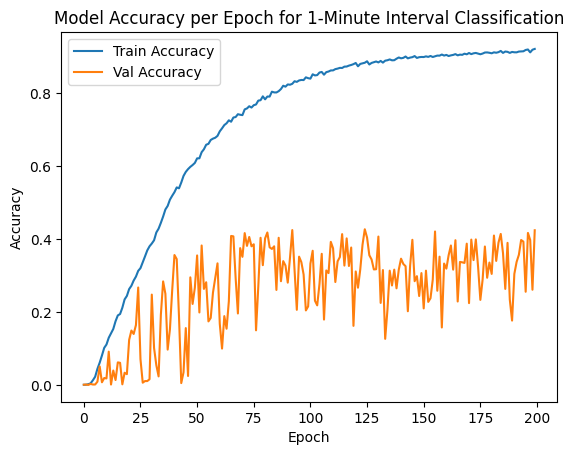

In [33]:
plt.title('Model Accuracy per Epoch for 1-Minute Interval Classification')
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_1min_interval.png')
plt.show()

In [47]:
evaluation_classification("model_classification_1.keras", X_train, X_val, X_test, y_test_720, interval=1)

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Common Sense Error Train set: 0h 0m
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Common Sense Error val set: 0h 27m
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4217 - loss: 1.7925
Test accuracy: 0.4216666519641876
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Common Sense Error: 0h 25m


Task 2.1 Regression

In [36]:
def time_to_minutes(y):
    return y[:,0] + y[:,1]/60

y_train_reg = time_to_minutes(y_train_orig)
y_val_reg = time_to_minutes(y_val_orig)
y_test_reg = time_to_minutes(y_test_orig)

In [37]:
model_regression = models.Sequential([
        layers.Input(shape=pixel_size),
        layers.Conv2D(32,7,padding='same',activation='relu',strides=3),
        layers.MaxPooling2D(pool_size=2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv2D(64,3,padding='same',activation='relu', strides=2),
        layers.Conv2D(128,3,padding='same',activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv2D(256,3,padding='same',activation='relu'),
        layers.Flatten(),
        layers.Dense(256,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256 ,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(1, activation='linear')
    ])


regression_checkpoint = ModelCheckpoint(
    filepath="model_regression.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=False
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.9,
    patience=5,
    verbose=1,
    min_lr=1e-4
)

model_regression.compile(optimizer=optimizers.Adam(1e-3), loss='mae', metrics=['mae'])
history_reg = model_regression.fit(X_train, y_train_reg, epochs=200, batch_size=64, validation_data=(X_val, y_val_reg), callbacks=[regression_checkpoint, lr_scheduler])

Epoch 1/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 4.2782 - mae: 4.2782 - val_loss: 3.0155 - val_mae: 3.0155 - learning_rate: 0.0010
Epoch 2/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.8376 - mae: 2.8376 - val_loss: 3.0429 - val_mae: 3.0429 - learning_rate: 0.0010
Epoch 3/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.5533 - mae: 2.5533 - val_loss: 2.5065 - val_mae: 2.5065 - learning_rate: 0.0010
Epoch 4/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.3174 - mae: 2.3174 - val_loss: 2.0710 - val_mae: 2.0710 - learning_rate: 0.0010
Epoch 5/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.0951 - mae: 2.0951 - val_loss: 1.8462 - val_mae: 1.8462 - learning_rate: 0.0010
Epoch 6/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.9076 - mae: 1.9076 - val_loss: 2.3286 - val_mae: 2.3286 - learning_rate: 0.0010
Epoch 7/200
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.7489 - mae: 1.7489 - val_loss: 1.2375 - val_mae: 1.2375 - learning_rate: 0.

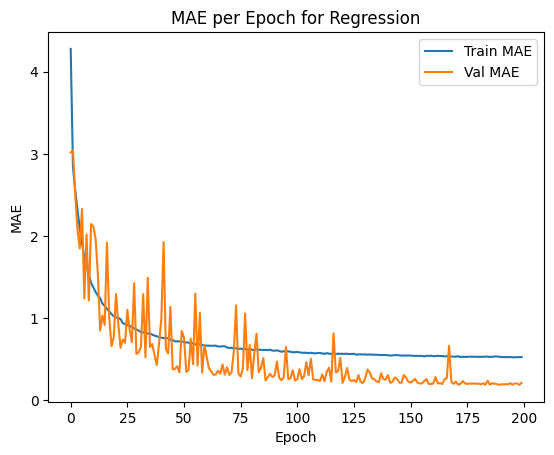

In [38]:
plt.title('MAE per Epoch for Regression')
plt.plot(history_reg.history['mae'], label='Train MAE')
plt.plot(history_reg.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.savefig('MAE_regression.png')
plt.show()

In [39]:
def common_sense_err_reg(y_total_minutes, y_pred_total_minutes):
    y_total_minutes = y_total_minutes * 60
    y_pred_total_minutes = y_pred_total_minutes *60
    diff = np.abs(y_total_minutes - y_pred_total_minutes)
    circular_diff = np.minimum(diff, 720 - diff)
    mean_error = int(np.mean(circular_diff))
    
    # convert back into hours and minutes
    mean_error_hours = mean_error // 60
    mean_error_minutes = mean_error % 60
    
    return mean_error_hours, mean_error_minutes


In [41]:
model = load_model("model_regression.keras")
y_pred = model.predict(X_train).flatten()
h, m = common_sense_err_reg(y_train_reg, y_pred)
print(f'Common Sense Error Train set: {h}h {m}m')
# evaluate on test set
train_mse, train_mae = model.evaluate(X_train, y_train_reg)
print('Train MAE:', train_mae)
y_pred = model.predict(X_val).flatten()
h, m = common_sense_err_reg(y_val_reg, y_pred)
print(f'Common Sense Error val set: {h}h {m}m')

# evaluate on test set
test_mse, test_mae = model.evaluate(X_test, y_test_reg)
print('Test MAE:', test_mae)

y_pred = model.predict(X_test).flatten()
h, m = common_sense_err_reg(y_test_reg, y_pred)
print(f'Common Sense Error: {h}h {m}m')


450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Common Sense Error Train set: 0h 6m
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1064 - mae: 0.1064
Train MAE: 0.10638799518346786
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Common Sense Error val set: 0h 10m
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1645 - mae: 0.1645 
Test MAE: 0.16448235511779785
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Common Sense Error: 0h 9m


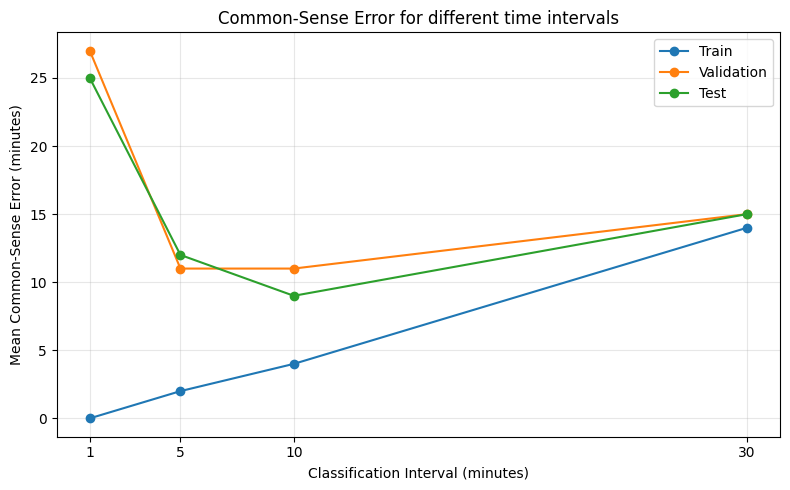

In [48]:
plt.figure(figsize=(8, 5))
intervals = [1, 5, 10, 30]
results_classification["train"] = results_classification["train"][::-1]
results_classification["val"] = results_classification["val"][::-1]
results_classification["test"] = results_classification["test"][::-1]

plt.plot(intervals, results_classification["train"], marker='o', label='Train')
plt.plot(intervals, results_classification["val"], marker='o', label='Validation')
plt.plot(intervals, results_classification["test"], marker='o', label='Test')

plt.title("Common-Sense Error for different time intervals")
plt.xlabel("Classification Interval (minutes)")
plt.ylabel("Mean Common-Sense Error (minutes)")
plt.xticks(intervals)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('common_sense_error_intervals.png')
plt.show()